In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import pickle
import tkinter as tk
from tkinter import ttk


In [4]:
# Instantiate the lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [5]:
# Function to prepare text
def prepare_text(text):
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    text = ' '.join(text)
    text = word_tokenize(text)
    text = pos_tag(text)
    lemma = []
    for i in text: lemma.append(wordnet_lemmatizer.lemmatize(i[0], pos = get_wordnet_pos(i[1])))
    lemma = ' '.join(lemma)
    return lemma

In [29]:
# Load dataset and preprocess
df = pd.read_csv('FinalBalancedDataset.csv')

df = df.drop("Unnamed: 0", axis=1)

df['clean_tweets'] = df['tweet'].apply(lambda x: prepare_text(x))
df


,Toxicity,tweet,clean_tweets
0,0,@user when a father is dysfunctional and is s...,user when a father be dysfunctional and be so ...
1,0,@user @user thanks for #lyft credit i can't us...,user user thanks for lyft credit i ca n't use ...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,0,factsguide: society now #motivation,factsguide society now motivation
...,...,...,...
56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you 's a muthaf in lie LifeAsKing Pearls corey...
56741,1,"you've gone and broke the wrong heart baby, an...",you 've go and break the wrong heart baby and ...
56742,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat dat nigguh like I aint f...
56743,1,youu got wild bitches tellin you lies,youu get wild bitch tellin you lie


In [7]:
# Preparing data for training(feature extraction)
corpus = df['clean_tweets'].values.astype('U')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit_transform(corpus)

In [8]:
# Saving the fitted vectorizer
pickle.dump(count_tf_idf, open("tf_idf.pkt", "wb"))

In [9]:
# Splitting data into training and testing sets
tf_idf_train, tf_idf_test, target_train, target_test = train_test_split(
    tf_idf, df['Toxicity'], test_size=0.8, random_state=42, shuffle=True
)

In [10]:
# Training the model
model_bayes = MultinomialNB()
model_bayes = model_bayes.fit(tf_idf_train, target_train)


In [11]:
# Calculating accuracy
predictions = model_bayes.predict(tf_idf_test)
accuracy = accuracy_score(target_test, predictions)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.91


In [12]:
# Calculating ROC AUC score
y_pred_proba = model_bayes.predict_proba(tf_idf_test)[:, 1]
final_roc_auc = roc_auc_score(target_test, y_pred_proba)
print(f"Model ROC AUC: {final_roc_auc:.2f}")

Model ROC AUC: 0.97


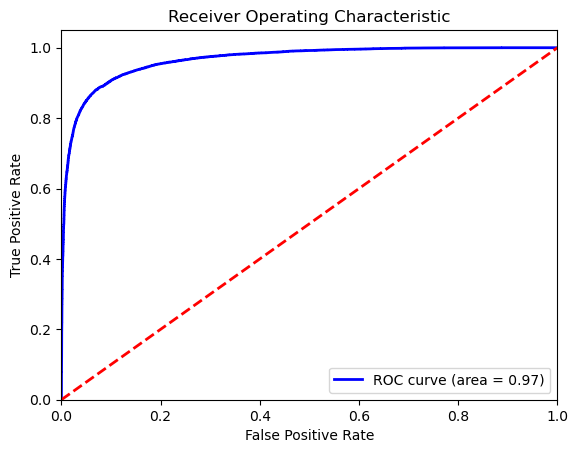

In [24]:
fpr, tpr, _ = roc_curve(target_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {final_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [47]:
# Saving the trained model
pickle.dump(model_bayes, open("toxicity_model.pkt", "wb"))

In [48]:
# Loading the model and TF-IDF vectorizer for user input
count_tf_idf = pickle.load(open("tf_idf.pkt", "rb"))
model_bayes = pickle.load(open("toxicity_model.pkt", "rb"))

In [49]:
# Predict toxicity function
def predict_toxicity():
    input_text = entry.get()  # Get input text from GUI
    clean_text = prepare_text(input_text)  # Preprocess the text
    tfidf_text = count_tf_idf.transform([clean_text])  # Transform the text using TF-IDF vectorizer
    prediction = model_bayes.predict(tfidf_text)  # Make prediction using Naive Bayes model
    prediction_proba = model_bayes.predict_proba(tfidf_text)  # Get prediction probabilities
    if prediction[0] == 1:
        result.set(f"Toxic (Probability: {prediction_proba[0][1]:.2f})")
    else:
        result.set(f"Not Toxic (Probability: {prediction_proba[0][0]:.2f})")

In [50]:
# Main window
root = tk.Tk()
root.title("Toxicity Classifier")

''

In [51]:
#input field
entry_label = ttk.Label(root, text="Enter a tweet/comment:")
entry_label.pack(pady=5)
entry = ttk.Entry(root, width=50)
entry.pack(pady=5)

#predict button
predict_button = ttk.Button(root, text="Classify", command=predict_toxicity)
predict_button.pack(pady=5)

#result label
result = tk.StringVar()
result_label = ttk.Label(root, textvariable=result)
result_label.pack(pady=5)

# Running the GUI event loop
root.mainloop()